#### NOTE: Before you begin this tutorial the [Upload the Activity Demo Project to SensiML Cloud](Getting%20Started%20-%20Tutorial%200%20-%20Project%20Upload.ipynb) using the Data Capture Lab

# Getting started with Knowledge Builder

In this Tutorial we are going to walk you through setting up the KnowledgeBuilder Data Science Kit, selecting data, and building a pipeline. The data you are going to use was collected from multiple subjects wearing a device with 6 sensors (Accelerometer x,y,z and Gyroscope x,y,z) and formatted using the Data Capture Lab. The goal is to build a model that is able to classify what type of activity the subjects were performing. By the end of this tutorial you should be able to query data, transform data streams into  a feature vector, train a model, and understand the quality of the model, as well as making sure the pipeline you have built will run on the hardware device. 

### Initialize a KB project

The data for this project has already been labeled and uploaded to the Project "Activity Case Study". To access the data first connect to the knowledgebuilder cloud service using the data science kit. And then set the project to "Activity Case Study."

Note: If you are running this tutorial outside of our workshop. You will want to use the project that you create in the getting started guide using the Data Capture Lab.

In [1]:
import sys
%matplotlib inline

from sensiml import SensiML
from sensiml.widgets import *

dsk = SensiML()

In [2]:
dsk.project ='Activity Demo'

The next step is to initialize a pipeline space to work in. The work you do in the pipeline will be stored in KB Cloud so that you can share pipelines with collaborators and come back to stored work in the future. Go ahead and add a pipeline to the project using the following code snippet. 
        
        dsk.pipeline = "Name of your pipeline"

In [3]:
dsk.pipeline = "Activity Demo"

## Part 1. Selecting the Data Set.

There are two ways of selecting data to use in a pipeline. The first is through a query against project data uploaded via the Data Capture Lab (DCL). The second is by uploading a pandas dataframe/csv data file. The DSK has useful functions for manipulating data in both ways. In this tutorial we will build a query against data that was uploaded through the Data Caputre Lab.

#### Query
* query_name: What we want to name our query. This name is also how you will retrieve the query in the future. 
* columns: The data columns that you would like to include. In our case, these columns are the sensor data from the device
        'AccelerometerZ'
        'AccelerometerY'
        'AccelerometerX'
* metadata_columns: This is additional information about your data set that is useful for separating out individual datastreams. In this example we have Subject and Activity. Subject relates to the individual user. Activity provides a ground truth about what type of activity the user was performing (running, walking, etc.).
* metadata_filter: This allows you to select a subset of the data by filtering against metadata.

You can use dsk to print the sensor columns and metadata columns that the project contains.

In [4]:
QueryWidget(dsk).create_widget()

HBox(children=(VBox(children=(Dropdown(description=u'Select Query', options=('', u'Q1', u'query_activity_demo', u'query_activity_wrist_twist', u'query_activity', u'query', u'query_activity_test'), value=''), Text(value=u'', description=u'Query Name'), Dropdown(description=u'Segmenter', options=(u'Manual',), value=u'Manual'), Dropdown(description=u'Label Column', options=(u'Activity', u'Subject'), value=u'Activity'), SelectMultiple(description=u'Metadtata', index=(1,), options=(u'Activity', u'Subject'), value=(u'Subject',)), SelectMultiple(description=u'Sources', index=(0, 1, 2, 3, 4, 5), options=(u'AccelerometerX', u'AccelerometerY', u'AccelerometerZ', u'GyroscopeX', u'GyroscopeY', u'GyroscopeZ'), value=(u'AccelerometerX', u'AccelerometerY', u'AccelerometerZ', u'GyroscopeX', u'GyroscopeY', u'GyroscopeZ')), Text(value=u'', description=u'Query Filter'), HBox(children=(Button(description=u'Add Query', style=ButtonStyle()), Button(description=u'Update Query', style=ButtonStyle()))))), Figure(background_style={'fill': 'white'}, fig_margin={'top': 20, 'left': 80, 'right': 0, 'bottom': 60}, layout=Layout(min_width=u'125px'), legend_location='bottom-right', scale_x=LinearScale(allow_padding=False, max=1.0, min=0.0), scale_y=LinearScale(allow_padding=False, max=1.0, min=0.0))))

/Users/chrisknorowski/.virtualenvs/dev2/lib/python2.7/site-packages/bqplot/traits.py:137: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(a.dtype, np.float):


# Part 2. Segmentation and Feature engineering

The Second part of the pipeline involves transforming data streams into a feature vector that are then used to train a model. The features in the feature vector must be integers between 0-255. The feature vector can be any length, but in practice you will be limited by the space on the device. 

DSK provides a way to define a pipeline for feature vector and model building. The feature vector generation part of the pipeline can be broken down into a few different parts:

* sensor transforms - these are applied to the data directly as it comes off the sensor, they can be smoothing functions, magnitude of sensor columns etc.
* segmentation - the segmenter selects regions of interest from the streaming data. This can be an event if you are using an event detection segmenter, or simply a sliding window which buffers a segment of data and sends it to the next step.
* segment transforms - operates on a segment of data, typically normalizes the data in some way such as demeaning to prepare for feature vector generation.
* feature generators - These functions extract relevant feature vectors from the data streams in preparation for model building.
* feature transforms - Feature transforms normalize all of the features in the feature vector to between between 0-255.
* feature selectors - These functions remove features which do not help descriminate between different classes.

The DSK allows you to string together a pipeline composed of these individual steps. The pipeline is sent to our servers where we can take advantage of optimizations to speed up the pipeline processing.

### Exploring the functions available on KB Cloud.

SensiML Cloud has a core functions available to use. To see a list of available functions simply do as follows: 

dsk.list_functions()

To get the documentation for any of the functions you can look at the KB documentation under core functions or use dsk.function_description("Function Name")

In [ ]:
dsk.function_description('Magnitude')

### Building the pipeline -  specifying the input data

Using the dsk, you will add sequential steps to the pipeline. It is important to note that until you execute the pipeline, i.e., dsk.pipeline.execute(), that no work is performed on the data. In other words, adding a transform to the pipeline does not immediately act on the data. Executing the function via dsk.pipleine.execute(), initiates the pipeline execution on KB Cloud, which will then return results. Because pipelines must be added sequentially, if you get things out of order or make an error, use the reset command to start fresh.
        
        dsk.pipeline.reset()
        


The first step in the pipeline must always be the data that you are going to work with. For us this is going to be the query you created with all of the sensor data. In the line below, place the cursor at the end of the function and press tab. Use the arrow keys to select set_input_query and hit enter. Then add the query name that you created the query with as input into the function.
    
        dsk.pipeline.set_input_query('<the name of your query>')

In [5]:
dsk.pipeline.reset()
dsk.pipeline.set_input_query('query_activity')

At any point in time you can list the steps and parameters in your pipeline.

In [13]:
dsk.pipeline.describe()

------------------------------------------------------------------------
 0.     Name: query_activity            		Type: query                    
------------------------------------------------------------------------
------------------------------------------------------------------------



If you want to see documentation about any of the kb client python functions, you can add a ? mark to the end of the file. Not all functions have documentation yet, but many of them do.

### Building the pipeline -  Adding a Transform

Now that we have specified the input data, let's go ahead and add a transform to the pipeline and execute the steps we've added so far on the cloud. 

To add the transforms we use the dsk.pipeline.add_transform( "function name", params ={"parameters to pass to function on server"}). In the function description you will see the parameters that need to be filled in.

One transform that is often useful for normalizing data is magnitude. There are different functions availble in kb client which help you with the function syntax. One of them is dsk.function_help()

In [14]:
dsk.pipeline.add_transform?

Note: To exit the information box, click on the small x at the top right of the box.

In [15]:
dsk.function_help('Magnitude')

dsk.pipeline.add_transform("Magnitude", params={"input_columns": <list>})


### Function snippets and description

You can also use dsk.snippets to autogenerate code and see what parameter values are accepted. 

        dsk.snippets.Transform.Magnitude()
        
This will replace the current cell with autogenerated code. Be careful not to execute a line like this in a pipeline cell with other data, as it will replace the entire cell, if you do this by accident you can always hit ctrl+z to undo. 

Go ahead and execute the cell below.

In [ ]:
dsk.snippets.Transform.Magnitude()

We want to take the maginute of the Gyroscope columns, so add them as an array to your input columns in the pipeline and execute the cell.



In [6]:
dsk.pipeline.add_transform("Magnitude", params={"input_columns": ['GyroscopeX','GyroscopeY', 'GyroscopeZ']})

you can use the following function at any time to see all of the steps and parameters that you currently have in your pipeline. 

In [7]:
dsk.pipeline.describe()

------------------------------------------------------------------------
 0.     Name: query_activity            		Type: query                    
------------------------------------------------------------------------
------------------------------------------------------------------------
 1.     Name: Magnitude                 		Type: transform                
------------------------------------------------------------------------

------------------------------------------------------------------------



### Pipeline Execution

When executing the pipeline, there will always be two results returned. The first will be the actual data and the second  contains information about the pipeline execution on the server. Feel free to explore the information in the second variable. It is often very useful. 

In [18]:
magnitude_data, stats = dsk.pipeline.execute()
magnitude_data.head()

Executing Pipeline with Steps:

------------------------------------------------------------------------
 0.     Name: query_activity            		Type: query                    
------------------------------------------------------------------------
------------------------------------------------------------------------
 1.     Name: Magnitude                 		Type: transform                
------------------------------------------------------------------------
------------------------------------------------------------------------


Checking for Results:

Retrieving page 1 of 1.

Results Retrieved.


,AccelerometerX,AccelerometerY,AccelerometerZ,Activity,GyroscopeX,GyroscopeY,GyroscopeZ,Magnitude_ST_0000,Subject
0,925.0,114.0,1640.0,counter-clockwise,4122.0,-554.0,494.0,4188,U001
1,923.0,210.0,1571.0,counter-clockwise,3963.0,-641.0,290.0,4025,U001
2,923.0,254.0,1415.0,counter-clockwise,3757.0,-695.0,52.0,3821,U001
3,901.0,371.0,1295.0,counter-clockwise,3532.0,-737.0,-225.0,3615,U001
4,862.0,460.0,1200.0,counter-clockwise,3308.0,-828.0,-494.0,3446,U001


Notice that an additional column is added to the dataframe - Magnitude_ST_0000. The subscripts refer to this being a sensor transform (ST) and being the first one added 0000. If you were to add another sensor transform, for example taking the magnitude of the accelerometer data as well, you would get another column Magnitude_ST_0001.

### Building the pipeline -  Performing Segmentation.

The next step is to segment our data into windows which we can perform recognition on. For the activity data we will use the Windowing Transform. Go ahead and look at the function description. Delta is the sliding window overlap. Setting delta to the same value as the window size means that there is no overlap in our segmented windows. 

In [8]:
dsk.pipeline.add_transform("Windowing", params={"window_size": 300, 
                                                "delta": 300,})
dsk.pipeline.describe(show_params=True)

------------------------------------------------------------------------
 0.     Name: query_activity            		Type: query                    
------------------------------------------------------------------------
------------------------------------------------------------------------
 1.     Name: Magnitude                 		Type: transform                
------------------------------------------------------------------------

------------------------------------------------------------------------
 2.     Name: Windowing                 		Type: segmenter                
------------------------------------------------------------------------
	Param: return_segment_index: False
	Param: window_size: 300
	Param: delta: 300
------------------------------------------------------------------------



Differnt window sizes can lead to better models. For this project lets reduce the window_size and delta to 200. The actual time that the window size represents for this data set it corresponds to 2 seconds, as our data was recorded at 100HZ. Go ahead and change the values in the Windowing Segmenter and re-execute. You will see the parameters change for the windowing segmenter change, but a new step shouldn't be added.

In [9]:
dsk.pipeline.add_transform("Windowing", params={"window_size": 200, 
                                                "delta": 200,})
dsk.pipeline.describe(show_params=True)

------------------------------------------------------------------------
 0.     Name: query_activity            		Type: query                    
------------------------------------------------------------------------
------------------------------------------------------------------------
 1.     Name: Magnitude                 		Type: transform                
------------------------------------------------------------------------

------------------------------------------------------------------------
 2.     Name: Windowing                 		Type: segmenter                
------------------------------------------------------------------------
	Param: return_segment_index: False
	Param: window_size: 200
	Param: delta: 200
------------------------------------------------------------------------



It is often good practice to pair a windowing segmentation algorithm with a filter. This will add a step in the pipeline that will drop segments, saving battery life on the device by ignoring segments that don't contain useful information. For this pipeline we want to use the "MSE Filter" transform. Go ahead and add this step to the pipeline. Use the function_description to figure out what parameters need to be filled in.

Note: Where default values are defined you don't need to set them as inputs unless you would like to change them.

In [10]:
dsk.pipeline.add_transform("MSE Filter", params={"input_column": 'Magnitude_ST_0000', 
                                                "MSE_target": -1.0, 
                                                "MSE_threshold": 0.01})

After adding the MSE filter execute the pipeline. 

In [22]:
mse_data, stats = dsk.pipeline.execute()

Executing Pipeline with Steps:

------------------------------------------------------------------------
 0.     Name: query_activity            		Type: query                    
------------------------------------------------------------------------
------------------------------------------------------------------------
 1.     Name: Magnitude                 		Type: transform                
------------------------------------------------------------------------
------------------------------------------------------------------------
 2.     Name: Windowing                 		Type: segmenter                
------------------------------------------------------------------------
------------------------------------------------------------------------
 3.     Name: MSE Filter                		Type: transform                
------------------------------------------------------------------------
------------------------------------------------------------------------


Checking for 

### Feature Vector Generation

At this point we are ready to generate a feature vector from our segments. Feature generators are all added into a single step and run in parallel against the same input data. We have added two feature generators from the subtype "Statistical". The more features, the better chance you have of building a successful model. Try adding a few more feature generators of the same subtype. 

In [ ]:
print dsk.functions

In [11]:
dsk.pipeline.add_feature_generator(["Mean", 'Standard Deviation','Sum', '25th Percentile'],
                                   function_defaults = {"columns":[u'Magnitude_ST_0000']})

Next, add the Min Max Scale transform to the pipeline. This function will scale the features in the feature vector to have values between 0 and 255.  

In [12]:
dsk.pipeline.add_transform('Min Max Scale')

In [13]:
feature_vectors, stats = dsk.pipeline.execute()

Executing Pipeline with Steps:

------------------------------------------------------------------------
 0.     Name: query_activity            		Type: query                    
------------------------------------------------------------------------
------------------------------------------------------------------------
 1.     Name: Magnitude                 		Type: transform                
------------------------------------------------------------------------
------------------------------------------------------------------------
 2.     Name: Windowing                 		Type: segmenter                
------------------------------------------------------------------------
------------------------------------------------------------------------
 3.     Name: MSE Filter                		Type: transform                
------------------------------------------------------------------------
------------------------------------------------------------------------
 4.     Name: g

Let us take a look at the feature vectors that you have generated. We plot of the average of all feature vectors grouped by Activity. Ideally, you are looking for feature vectors that are separable in space. How do the ones you've generated look? 


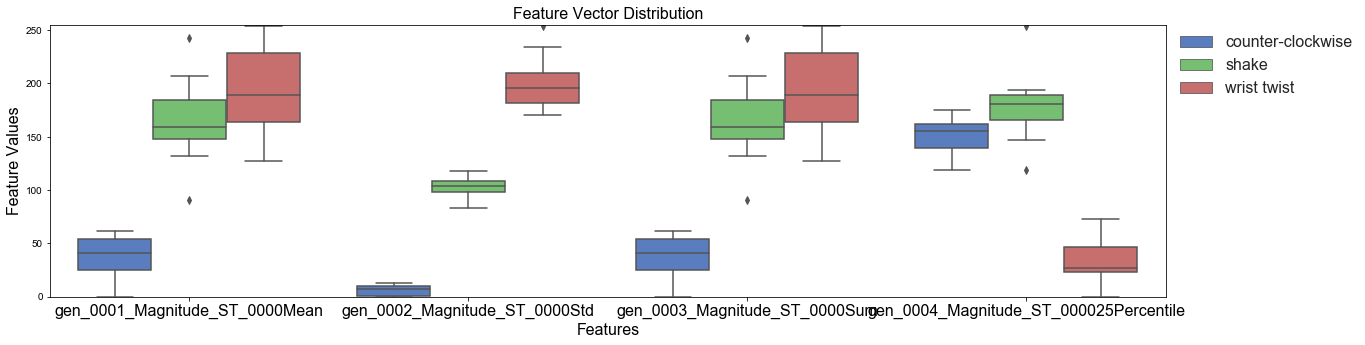

In [15]:
dsk.pipeline.visualize_features(feature_vectors)

# Part 3. Model Building - Creating a model to put onto a device.

### Model TVO description

* train_validate_optimze (tvo) : This step defines the model validation, the classifier and the training algorithm to build the model with. On KB Cloud the model is first trained using the selected training algorithm, then loaded into the hardware simulator (currently we only support pattern matching, but more algorithms will be added in the future) and tested using the specified validation method.

This pipeline uses the validation method "Stratified K-Fold Cross-Validation". This is a standard validation method used to test the performance of a model by splitting the data into k folds, training on k-1 folds and testing against the excluded fold. Then it switches which fold is tested on, and repeats until all of the folds have been used as a test set. The average of the metrics for each model provide you with a good estimate of how a model trained on the full data set will perform.

The training algorithm attempts to optimize the number of neurons and their locations in order to create the best model. We are using the training algorithm "Hierarchical Clustering with Neuron Optimization," which uses a clustering algorithm to optimize neurons placement in feature space. 

The only classifier currently available in KB Cloud is PME. PME has two classification modes, RBF and KNN and two distance modes of calculation, L1 and LSUP. You can see the documentation for further descriptions of the classifier.

In [16]:
dsk.pipeline.set_validation_method('Stratified K-Fold Cross-Validation', params={'number_of_folds':3,})

dsk.pipeline.set_classifier('PVP', params={"classification_mode":'RBF','distance_mode':'L1'})

dsk.pipeline.set_training_algorithm('Hierarchical Clustering with Neuron Optimization', params = {'number_of_neurons':5})


dsk.pipeline.set_tvo({'validation_seed':2})

Go ahead and execute the full pipeline now.

In [17]:
model_results, stats = dsk.pipeline.execute()

Executing Pipeline with Steps:

------------------------------------------------------------------------
 0.     Name: query_activity            		Type: query                    
------------------------------------------------------------------------
------------------------------------------------------------------------
 1.     Name: Magnitude                 		Type: transform                
------------------------------------------------------------------------
------------------------------------------------------------------------
 2.     Name: Windowing                 		Type: segmenter                
------------------------------------------------------------------------
------------------------------------------------------------------------
 3.     Name: MSE Filter                		Type: transform                
------------------------------------------------------------------------
------------------------------------------------------------------------
 4.     Name: g

The model_results object returned after a TVO step contains a wealth of information about the models that were generated and their performance. A simple view is to use the summarize function to see the performance of our model.

In [18]:
model_results.summarize()

TRAINING ALGORITHM: Hierarchical Clustering with Neuron Optimization
VALIDATION METHOD:  Stratified K-Fold Cross-Validation
CLASSIFIER:         PVP

AVERAGE METRICS:
F1-SCORE:    77.9   sigma 13.38
SENSITIVITY: 100.0   sigma 0.00
PRECISION:   69.1   sigma 17.86

--------------------------------------

STRATIFIED K-FOLD CROSS-VALIDATION MODEL RESULTS

MODEL INDEX: Fold 2
ACCURACY: 88.89
NEURONS: 3

MODEL INDEX: Fold 1
ACCURACY: 72.73
NEURONS: 3

MODEL INDEX: Fold 0
ACCURACY: 41.67
NEURONS: 3



Let's grab the fold with the best performing model to compare with our features.

In [21]:
model = model_results.configurations[0].models[0]

The neurons are contained in model.neurons. Plot these over the feature_vector plot that you created earlier. This step is often useful for debugging.

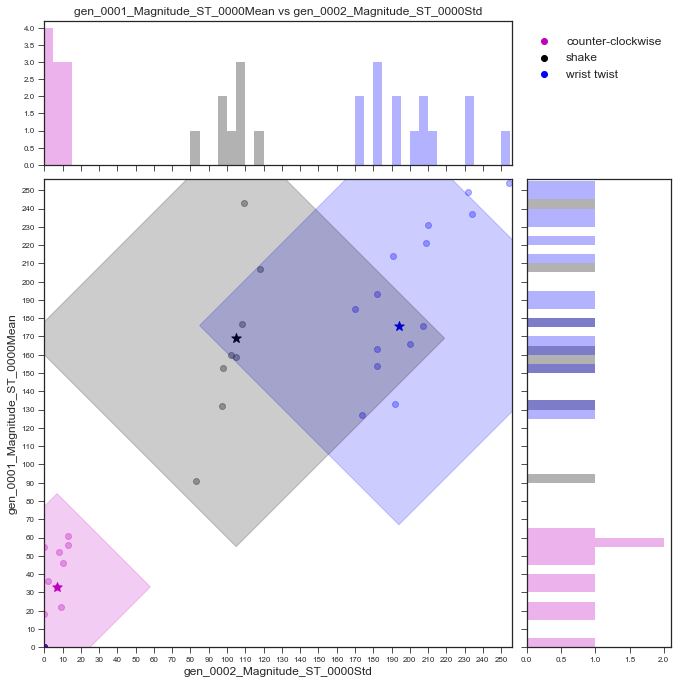

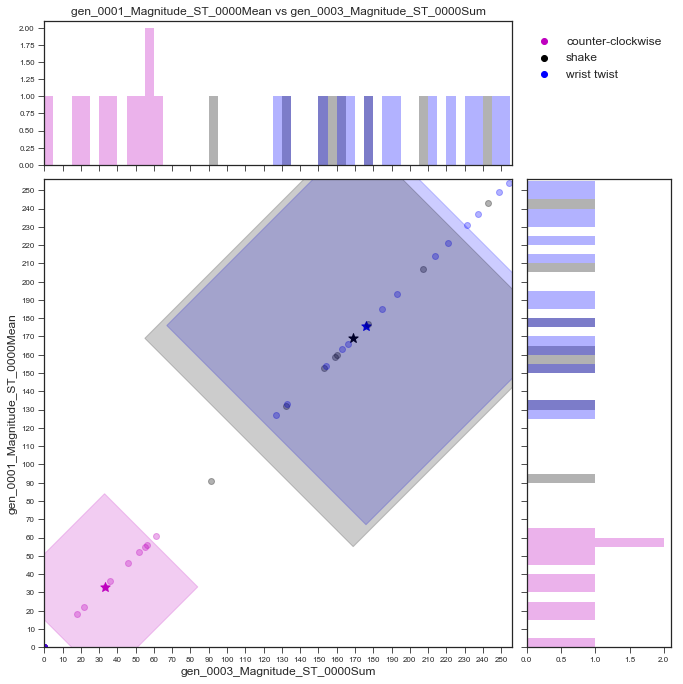

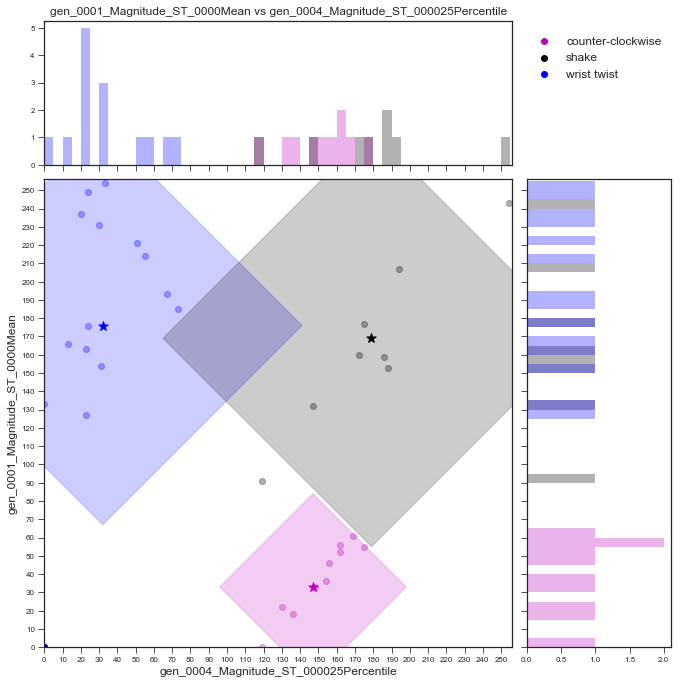

In [29]:
dsk.pipeline.visualize_neuron_array(model, feature_vectors, feature_vectors.columns[3], feature_vectors.columns[4:])

go ahead and save the best model with a name. Models that aren't saved will be lost when the cache is emptied.

In [25]:
model.knowledgepack.save('ActivityKP')

Knowledgepack name updated.


# Part 4. The power of KnowledgeBuilder - KnowledgePacks 

The most important objective of KnowledgeBuilder is to allow users to instantly turn their models into downloadable KnowledgePacks that can be flashed to devices to perform the classification tasks. To download a knowledpack use the download knowledgpack widget.


### Download Knowledpack

Finally, lets download our knowledpack. We have saved the knowledpack with the name ActivityKP, select that in the widget below. Then select your target platform. Specify:

In [27]:
DownloadWidget(dsk).create_widget()

VBox(children=(HBox(children=(Dropdown(description=u'Model Name', options={u'ActivityKP': u'724df577-b100-4ef3-a1f0-98a06ac921bd', u'ActivityKP2': u'e2613d70-fddc-4c35-94f3-9e2c37d5f73a'}, value=u'724df577-b100-4ef3-a1f0-98a06ac921bd'), Button(description=u'Refresh', icon=u'0', layout=Layout(align_items=u'flex-start', border=u'solid 2px', display=u'flex', flex_flow=u'column', justify_content=u'center', overflow=u'visible', width=u'25%'), style=ButtonStyle()), Button(description=u'Generate Knowledgepack', icon=u'0', layout=Layout(align_items=u'flex-start', border=u'solid 2px', display=u'flex', flex_flow=u'column', justify_content=u'center', overflow=u'visible', width=u'25%'), style=ButtonStyle()))), Label(value=u'Download Settings', layout=Layout(justify_content=u'flex-start', overflow=u'visible')), HBox(children=(VBox(children=(Dropdown(description=u'HW Platform', index=1, options={'Curie Reference 4.1': 1, 'Nordic Thingy 2.1': 2, 'Amulet 4.1': 0}, value=2), Dropdown(description=u'Target OS', options=('NordicSDK',), value='NordicSDK'), Dropdown(description=u'Download', options=('Binary', 'Library'), value='Binary'))), VBox(children=(Dropdown(description=u'IMU Rate', options=(100, 50, 25), value=100), Dropdown(description=u'Debug', options=(True, False), value=True), Dropdown(description=u'Test Data', options=(None,), value=None))), SelectMultiple(description=u'Output', index=(0,), options=('ble', 'led', 'serial'), value=('ble',))))))